In [54]:
import numpy as np
import pandas as pd 
import os
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [55]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A 

In [56]:
import albumentations as A 

In [57]:
import matplotlib.pyplot as plt

In [58]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cpu
0.15.2+cpu


In [59]:
import pycocotools

In [60]:
from albumentations.pytorch import ToTensorV2

In [61]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [62]:
__author__ = 'tylin'
__version__ = '2.0'
# Interface for accessing the Microsoft COCO dataset.

# Microsoft COCO is a large image dataset designed for object detection,
# segmentation, and caption generation. pycocotools is a Python API that
# assists in loading, parsing and visualizing the annotations in COCO.
# Please visit http://mscoco.org/ for more information on COCO, including
# for the data, paper, and tutorials. The exact format of the annotations
# is also described on the COCO website. For example usage of the pycocotools
# please see pycocotools_demo.ipynb. In addition to this API, please download both
# the COCO images and annotations in order to run the demo.

# An alternative to using the API is to load the annotations directly
# into Python dictionary
# Using the API provides additional utility functions. Note that this API
# supports both *instance* and *caption* annotations. In the case of
# captions not all functions are defined (e.g. categories are undefined).

# The following API functions are defined:
#  COCO       - COCO api class that loads COCO annotation file and prepare data structures.
#  decodeMask - Decode binary mask M encoded via run-length encoding.
#  encodeMask - Encode binary mask M using run-length encoding.
#  getAnnIds  - Get ann ids that satisfy given filter conditions.
#  getCatIds  - Get cat ids that satisfy given filter conditions.
#  getImgIds  - Get img ids that satisfy given filter conditions.
#  loadAnns   - Load anns with the specified ids.
#  loadCats   - Load cats with the specified ids.
#  loadImgs   - Load imgs with the specified ids.
#  annToMask  - Convert segmentation in an annotation to binary mask.
#  showAnns   - Display the specified annotations.
#  loadRes    - Load algorithm results and create API for accessing them.
#  download   - Download COCO images from mscoco.org server.
# Throughout the API "ann"=annotation, "cat"=category, and "img"=image.
# Help on each functions can be accessed by: "help COCO>function".

# See also COCO>decodeMask,
# COCO>encodeMask, COCO>getAnnIds, COCO>getCatIds,
# COCO>getImgIds, COCO>loadAnns, COCO>loadCats,
# COCO>loadImgs, COCO>annToMask, COCO>showAnns

# Microsoft COCO Toolbox.      version 2.0
# Data, paper, and tutorials available at:  http://mscoco.org/
# Code written by Piotr Dollar and Tsung-Yi Lin, 2014.
# Licensed under the Simplified BSD License [see bsd.txt]

import json
import time
import numpy as np
import copy
import itertools
# from . import mask as maskUtils
import os
from collections import defaultdict
import sys
PYTHON_VERSION = sys.version_info[0]
if PYTHON_VERSION == 2:
    from urllib import urlretrieve
elif PYTHON_VERSION == 3:
    from urllib.request import urlretrieve


def _isArrayLike(obj):
    return hasattr(obj, '__iter__') and hasattr(obj, '__len__')


class COCO:
    def __init__(self, annotation_file=None):
        """
        Constructor of Microsoft COCO helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :param image_folder (str): location to the folder that hosts images.
        :return:
        """
        # load dataset
        self.dataset,self.anns,self.cats,self.imgs = dict(),dict(),dict(),dict()
        self.imgToAnns, self.catToImgs = defaultdict(list), defaultdict(list)
        if not annotation_file == None:
            print('loading annotations into memory...')
            tic = time.time()
            with open(annotation_file, 'r') as f:
                dataset = json.load(f)
            assert type(dataset)==dict, 'annotation file format {} not supported'.format(type(dataset))
            print('Done (t={:0.2f}s)'.format(time.time()- tic))
            self.dataset = dataset
            self.createIndex()

    def createIndex(self):
        # create index
        print('creating index...')
        anns, cats, imgs = {}, {}, {}
        imgToAnns,catToImgs = defaultdict(list),defaultdict(list)
        if 'annotations' in self.dataset:
            for ann in self.dataset['annotations']:
                imgToAnns[ann['image_id']].append(ann)
                anns[ann['id']] = ann

        if 'images' in self.dataset:
            for img in self.dataset['images']:
                imgs[img['id']] = img

        if 'categories' in self.dataset:
            for cat in self.dataset['categories']:
                cats[cat['id']] = cat

        if 'annotations' in self.dataset and 'categories' in self.dataset:
            for ann in self.dataset['annotations']:
                catToImgs[ann['category_id']].append(ann['image_id'])

        print('index created!')

        # create class members
        self.anns = anns
        self.imgToAnns = imgToAnns
        self.catToImgs = catToImgs
        self.imgs = imgs
        self.cats = cats

    def info(self):
        """
        Print information about the annotation file.
        :return:
        """
        for key, value in self.dataset['info'].items():
            print('{}: {}'.format(key, value))

    def getAnnIds(self, imgIds=[], catIds=[], areaRng=[], iscrowd=None):
        """
        Get ann ids that satisfy given filter conditions. default skips that filter
        :param imgIds  (int array)     : get anns for given imgs
               catIds  (int array)     : get anns for given cats
               areaRng (float array)   : get anns for given area range (e.g. [0 inf])
               iscrowd (boolean)       : get anns for given crowd label (False or True)
        :return: ids (int array)       : integer array of ann ids
        """
        imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(imgIds) == len(catIds) == len(areaRng) == 0:
            anns = self.dataset['annotations']
        else:
            if not len(imgIds) == 0:
                lists = [self.imgToAnns[imgId] for imgId in imgIds if imgId in self.imgToAnns]
                anns = list(itertools.chain.from_iterable(lists))
            else:
                anns = self.dataset['annotations']
            anns = anns if len(catIds)  == 0 else [ann for ann in anns if ann['category_id'] in catIds]
            anns = anns if len(areaRng) == 0 else [ann for ann in anns if ann['area'] > areaRng[0] and ann['area'] < areaRng[1]]
        if not iscrowd == None:
            ids = [ann['id'] for ann in anns if ann['iscrowd'] == iscrowd]
        else:
            ids = [ann['id'] for ann in anns]
        return ids

    def getCatIds(self, catNms=[], supNms=[], catIds=[]):
        """
        filtering parameters. default skips that filter.
        :param catNms (str array)  : get cats for given cat names
        :param supNms (str array)  : get cats for given supercategory names
        :param catIds (int array)  : get cats for given cat ids
        :return: ids (int array)   : integer array of cat ids
        """
        catNms = catNms if _isArrayLike(catNms) else [catNms]
        supNms = supNms if _isArrayLike(supNms) else [supNms]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(catNms) == len(supNms) == len(catIds) == 0:
            cats = self.dataset['categories']
        else:
            cats = self.dataset['categories']
            cats = cats if len(catNms) == 0 else [cat for cat in cats if cat['name']          in catNms]
            cats = cats if len(supNms) == 0 else [cat for cat in cats if cat['supercategory'] in supNms]
            cats = cats if len(catIds) == 0 else [cat for cat in cats if cat['id']            in catIds]
        ids = [cat['id'] for cat in cats]
        return ids

    def getImgIds(self, imgIds=[], catIds=[]):
        '''
        Get img ids that satisfy given filter conditions.
        :param imgIds (int array) : get imgs for given ids
        :param catIds (int array) : get imgs with all given cats
        :return: ids (int array)  : integer array of img ids
        '''
        imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(imgIds) == len(catIds) == 0:
            ids = self.imgs.keys()
        else:
            ids = set(imgIds)
            for i, catId in enumerate(catIds):
                if i == 0 and len(ids) == 0:
                    ids = set(self.catToImgs[catId])
                else:
                    ids &= set(self.catToImgs[catId])
        return list(ids)

    def loadAnns(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying anns
        :return: anns (object array) : loaded ann objects
        """
        if _isArrayLike(ids):
            return [self.anns[id] for id in ids]
        elif type(ids) == int:
            return [self.anns[ids]]

    def loadCats(self, ids=[]):
        """
        Load cats with the specified ids.
        :param ids (int array)       : integer ids specifying cats
        :return: cats (object array) : loaded cat objects
        """
        if _isArrayLike(ids):
            return [self.cats[id] for id in ids]
        elif type(ids) == int:
            return [self.cats[ids]]

    def loadImgs(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying img
        :return: imgs (object array) : loaded img objects
        """
        if _isArrayLike(ids):
            return [self.imgs[id] for id in ids]
        elif type(ids) == int:
            return [self.imgs[ids]]

    def showAnns(self, anns, draw_bbox=False):
        """
        Display the specified annotations.
        :param anns (array of object): annotations to display
        :return: None
        """
        if len(anns) == 0:
            return 0
        if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
            datasetType = 'instances'
        elif 'caption' in anns[0]:
            datasetType = 'captions'
        else:
            raise Exception('datasetType not supported')
        if datasetType == 'instances':
            import matplotlib.pyplot as plt
            from matplotlib.collections import PatchCollection
            from matplotlib.patches import Polygon

            ax = plt.gca()
            ax.set_autoscale_on(False)
            polygons = []
            color = []
            for ann in anns:
                c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
                if 'segmentation' in ann:
                    if type(ann['segmentation']) == list:
                        # polygon
                        for seg in ann['segmentation']:
                            poly = np.array(seg).reshape((int(len(seg)/2), 2))
                            polygons.append(Polygon(poly))
                            color.append(c)
                    else:
                        # mask
                        t = self.imgs[ann['image_id']]
                        if type(ann['segmentation']['counts']) == list:
                            rle = maskUtils.frPyObjects([ann['segmentation']], t['height'], t['width'])
                        else:
                            rle = [ann['segmentation']]
                        m = maskUtils.decode(rle)
                        img = np.ones( (m.shape[0], m.shape[1], 3) )
                        if ann['iscrowd'] == 1:
                            color_mask = np.array([2.0,166.0,101.0])/255
                        if ann['iscrowd'] == 0:
                            color_mask = np.random.random((1, 3)).tolist()[0]
                        for i in range(3):
                            img[:,:,i] = color_mask[i]
                        ax.imshow(np.dstack( (img, m*0.5) ))
                if 'keypoints' in ann and type(ann['keypoints']) == list:
                    # turn skeleton into zero-based index
                    sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
                    kp = np.array(ann['keypoints'])
                    x = kp[0::3]
                    y = kp[1::3]
                    v = kp[2::3]
                    for sk in sks:
                        if np.all(v[sk]>0):
                            plt.plot(x[sk],y[sk], linewidth=3, color=c)
                    plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
                    plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

                if draw_bbox:
                    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
                    poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
                    np_poly = np.array(poly).reshape((4,2))
                    polygons.append(Polygon(np_poly))
                    color.append(c)

            p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        elif datasetType == 'captions':
            for ann in anns:
                print(ann['caption'])

    def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = COCO()
        res.dataset['images'] = [img for img in self.dataset['images']]

        print('Loading and preparing results...')
        tic = time.time()
        if type(resFile) == str or (PYTHON_VERSION == 2 and type(resFile) == unicode):
            with open(resFile) as f:
                anns = json.load(f)
        elif type(resFile) == np.ndarray:
            anns = self.loadNumpyAnnotations(resFile)
        else:
            anns = resFile
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [ann['image_id'] for ann in anns]
        assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
               'Results do not correspond to current coco set'
        if 'caption' in anns[0]:
            imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
            res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
            for id, ann in enumerate(anns):
                ann['id'] = id+1
        elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                bb = ann['bbox']
                x1, x2, y1, y2 = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
                if not 'segmentation' in ann:
                    ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
                ann['area'] = bb[2]*bb[3]
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'segmentation' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                # now only support compressed RLE format as segmentation results
                ann['area'] = maskUtils.area(ann['segmentation'])
                if not 'bbox' in ann:
                    ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'keypoints' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                s = ann['keypoints']
                x = s[0::3]
                y = s[1::3]
                x0,x1,y0,y1 = np.min(x), np.max(x), np.min(y), np.max(y)
                ann['area'] = (x1-x0)*(y1-y0)
                ann['id'] = id + 1
                ann['bbox'] = [x0,y0,x1-x0,y1-y0]
        print('DONE (t={:0.2f}s)'.format(time.time()- tic))

        res.dataset['annotations'] = anns
        res.createIndex()
        return res

    def download(self, tarDir = None, imgIds = [] ):
        '''
        Download COCO images from mscoco.org server.
        :param tarDir (str): COCO results directory name
               imgIds (list): images to be downloaded
        :return:
        '''
        if tarDir is None:
            print('Please specify target directory')
            return -1
        if len(imgIds) == 0:
            imgs = self.imgs.values()
        else:
            imgs = self.loadImgs(imgIds)
        N = len(imgs)
        if not os.path.exists(tarDir):
            os.makedirs(tarDir)
        for i, img in enumerate(imgs):
            tic = time.time()
            fname = os.path.join(tarDir, img['file_name'])
            if not os.path.exists(fname):
                urlretrieve(img['coco_url'], fname)
            print('downloaded {}/{} images (t={:0.1f}s)'.format(i, N, time.time()- tic))

    def loadNumpyAnnotations(self, data):
        """
        Convert result data from a numpy array [Nx7] where each row contains {imageID,x1,y1,w,h,score,class}
        :param  data (numpy.ndarray)
        :return: annotations (python nested list)
        """
        print('Converting ndarray to lists...')
        assert(type(data) == np.ndarray)
        print(data.shape)
        assert(data.shape[1] == 7)
        N = data.shape[0]
        ann = []
        for i in range(N):
            if i % 1000000 == 0:
                print('{}/{}'.format(i,N))
            ann += [{
                'image_id'  : int(data[i, 0]),
                'bbox'  : [ data[i, 1], data[i, 2], data[i, 3], data[i, 4] ],
                'score' : data[i, 5],
                'category_id': int(data[i, 6]),
                }]
        return ann

    def annToRLE(self, ann):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        t = self.imgs[ann['image_id']]
        h, w = t['height'], t['width']
        segm = ann['segmentation']
        if type(segm) == list:
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, h, w)
            rle = maskUtils.merge(rles)
        elif type(segm['counts']) == list:
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, h, w)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann)
        m = maskUtils.decode(rle)
        return m


In [63]:
dataset_path = "Aquarium Combined/"


In [64]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [65]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [66]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [67]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [68]:
train_dataset

Dataset AquariumDetection
    Number of datapoints: 447
    Root location: Aquarium Combined/
    Compose([
  Resize(always_apply=False, p=1, height=600, width=600, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.3),
  VerticalFlip(always_apply=False, p=0.3),
  RandomBrightnessContrast(always_apply=False, p=0.1, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  ColorJitter(always_apply=False, p=0.1, brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=[-0.2, 0.2]),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={}, is_check_shapes=True)

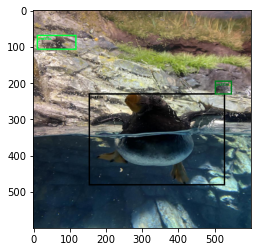

In [69]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [70]:
len(train_dataset)

447

In [71]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [72]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [73]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [74]:
train_loader

In [75]:
next(iter(train_loader))

((tensor([[[0.3059, 0.3020, 0.2941,  ..., 0.1725, 0.1882, 0.2314],
           [0.3176, 0.3098, 0.3020,  ..., 0.1843, 0.1804, 0.2000],
           [0.3098, 0.3059, 0.3020,  ..., 0.1882, 0.1843, 0.1922],
           ...,
           [0.0235, 0.0275, 0.0235,  ..., 0.0941, 0.0902, 0.0902],
           [0.0235, 0.0235, 0.0235,  ..., 0.0902, 0.0902, 0.0863],
           [0.0196, 0.0235, 0.0196,  ..., 0.0902, 0.0902, 0.0941]],
  
          [[0.3686, 0.3647, 0.3569,  ..., 0.2314, 0.2471, 0.2902],
           [0.3765, 0.3686, 0.3608,  ..., 0.2431, 0.2392, 0.2588],
           [0.3686, 0.3647, 0.3608,  ..., 0.2471, 0.2431, 0.2510],
           ...,
           [0.0078, 0.0118, 0.0196,  ..., 0.0902, 0.0902, 0.0863],
           [0.0078, 0.0078, 0.0196,  ..., 0.0941, 0.0902, 0.0863],
           [0.0039, 0.0078, 0.0157,  ..., 0.0941, 0.0941, 0.0941]],
  
          [[0.4706, 0.4667, 0.4588,  ..., 0.3922, 0.4078, 0.4510],
           [0.4902, 0.4824, 0.4745,  ..., 0.4039, 0.4000, 0.4196],
           [0.4824, 0.

In [76]:
images,targets = next(iter(train_loader))
 

In [77]:
images = list(image for image in images)


In [78]:
targets = [{k:v for k, v in t.items()} for t in targets]


In [79]:
output = model(images, targets)

In [89]:
device = torch.device("cpu")

In [90]:
from torch import nn
net = nn.Sequential(
    nn.Linear(18*18, 80),
    nn.ReLU(),
    nn.Linear(80, 80),
    nn.ReLU(),
    nn.Linear(80, 10),
    nn.LogSoftmax()
)

In [91]:
model = model.to()

In [92]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [93]:
import sys

In [94]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    

    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        

        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [95]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 112/112 [15:06<00:00,  8.10s/it]


Epoch 0, lr: 0.010000, loss: 0.975824, loss_classifier: 0.459300, loss_box: 0.396860, loss_rpn_box: 0.032392, loss_object: 0.087272


100%|██████████| 112/112 [1:05:17<00:00, 34.98s/it]  


Epoch 1, lr: 0.010000, loss: 0.780837, loss_classifier: 0.350837, loss_box: 0.343830, loss_rpn_box: 0.028290, loss_object: 0.057880


100%|██████████| 112/112 [14:14<00:00,  7.63s/it]


Epoch 2, lr: 0.010000, loss: 0.733144, loss_classifier: 0.304715, loss_box: 0.355850, loss_rpn_box: 0.026189, loss_object: 0.046391


100%|██████████| 112/112 [14:14<00:00,  7.63s/it]


Epoch 3, lr: 0.010000, loss: 0.688012, loss_classifier: 0.278013, loss_box: 0.341329, loss_rpn_box: 0.025518, loss_object: 0.043152


100%|██████████| 112/112 [13:54<00:00,  7.45s/it]


Epoch 4, lr: 0.010000, loss: 0.655665, loss_classifier: 0.249742, loss_box: 0.345201, loss_rpn_box: 0.024440, loss_object: 0.036282


100%|██████████| 112/112 [13:23<00:00,  7.18s/it]


Epoch 5, lr: 0.010000, loss: 0.659949, loss_classifier: 0.249408, loss_box: 0.356637, loss_rpn_box: 0.022699, loss_object: 0.031205


100%|██████████| 112/112 [13:54<00:00,  7.45s/it]


Epoch 6, lr: 0.010000, loss: 0.655802, loss_classifier: 0.250248, loss_box: 0.352701, loss_rpn_box: 0.022627, loss_object: 0.030226


100%|██████████| 112/112 [13:13<00:00,  7.08s/it]


Epoch 7, lr: 0.010000, loss: 0.645583, loss_classifier: 0.250152, loss_box: 0.346184, loss_rpn_box: 0.021899, loss_object: 0.027347


100%|██████████| 112/112 [13:08<00:00,  7.04s/it]


Epoch 8, lr: 0.010000, loss: 0.637020, loss_classifier: 0.235698, loss_box: 0.352896, loss_rpn_box: 0.021548, loss_object: 0.026878


100%|██████████| 112/112 [13:07<00:00,  7.03s/it]

Epoch 9, lr: 0.010000, loss: 0.623007, loss_classifier: 0.231472, loss_box: 0.345429, loss_rpn_box: 0.020183, loss_object: 0.025924


In [96]:
model.eval()
torch.cuda.empty_cache()

In [97]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [98]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

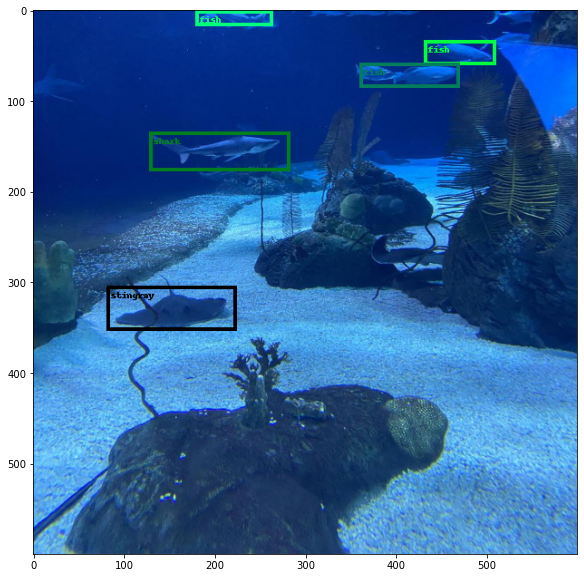

In [99]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))